['+Other', '+I>C']
cmd_try : 19 experiments; average of 22.26 subjects per experiment
cmd_try - loading ALE
cmd_try - loading null PDF
cmd_try - computing p-values & TFCE


KeyboardInterrupt: 

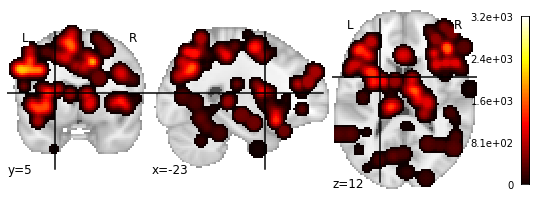

In [8]:
import argparse
import pickle
import os
from os.path import isfile, isdir
import pandas as pd
from main_effect import main_effect
from contrast import contrast
from legacy_contrast import legacy_contrast
from compile_studies import compile_studies
from contribution import contribution
from folder_setup import folder_setup
from roi import check_rois
from read_exp_info import read_exp_info



parser = argparse.ArgumentParser(description='Initates ALE Meta-Analysis.')
parser.add_argument('--file', metavar='f', type=str, required=True, help='File that stores study information (coordinates, etc.)')
parser.add_argument('--type', metavar='t', type=str, required=True, help='Type of Analysis; check instructions file for possible types')
parser.add_argument('--name', metavar='n', type=str, required=True, help='Name given to analysis; used for provenance tracking')
parser.add_argument('--cats', metavar='c', type=str, nargs='+', default="All", help='Categories of experiments to include in analysis; check instructions file for syntax')
parser.add_argument('-name2', metavar='n2', type=str, help='for contrasts there needs to be a 2nd analysis specified; name of the second')
parser.add_argument('-cats2', metavar='c2', type=str, help='categories for 2nd analysis')
args = parser.parse_args(["--f", "experiment_info.xlsx", "--t", "M", "--n", "cmd_try", "--cats", "+Other", "+I>C"])

file = args.file
type_ = args.type
exp_name = args.name
conditions = args.cats
if type_[0] in ["C", "B"]:
    if args.name2 is None:
        print("When selecting one of the contrast procedures a 2nd analysis needs to be specified. Please check --help for syntax specifics.")
        #exit()
    else:
        name2 = args.name2
        conditions2 = args.cats2
        file2 = args.file2
        
print(conditions)

        
if not isdir("Results"):
    os.mkdir("Results")

if isfile(f'Results/{file}.pickle'):
    with open(f'Results/{file}.pickle', 'rb') as f:
        exp_all, tasks = pickle.load(f)
else:
    exp_all, tasks = read_exp_info(f'{file}')

if type_ == "M":
    if not isdir("Results/MainEffect/Full"):
        folder_setup(path, "MainEffect_Full")
    exp_idxs, masks, mask_names = compile_studies(conditions, tasks)
    exp_df = exp_all.loc[exp_idxs].reset_index(drop=True)
    if len(exp_idxs) >= 12: 
        print(f'{exp_name} : {len(exp_idxs)} experiments; average of {exp_df.Subjects.mean():.2f} subjects per experiment')
        main_effect(exp_df, exp_name, cluster_thresh=0.001, null_repeats=1000)
        contribution(exp_df, exp_name, exp_idxs, tasks)
    else:
        print(f"{exp_name} : only {len(exp_idxs)} experiments - not analyzed!")

    if len(masks) > 0:
        print(f"{exp_name} - ROI analysis")
        if not isdir("Results/MainEffect/ROI"):
            folder_setup(path, "MainEffect_ROI")   
        with open(f"Results/MainEffect/Full/NullDistributions/{exp_name}_null.pickle", 'rb') as f:
            null_ale, _, _, _ = pickle.load(f) 
        null_ale = np.stack(null_ale)
        check_rois(exp_df, exp_name, masks, mask_names, null_repeats=1000, null_ale=null_ale)

if type_[0] == "P":
    if not isdir("Results/MainEffect/CV"):
        folder_setup(path, "MainEffect_CV")
    exp_idxs, _, _ = compile_studies(conditions, tasks)
    exp_df = exp_all.loc[exp_idxs].reset_index(drop=True)
    if len(type_) > 1:
        target_n = type_[1:]
        main_effect(exp_df, exp_name, null_repeats=1000, target_n=target_n, sample_n=2500)
    else:
        print(f"{exp_name}: need to specify subsampling")

if type_ == "C":
    if not isdir("Results/Contrast/Full"):
        folder_setup(path, "Contrast_Full")
    exp_idx1, masks, mask_names = compile_studies(conditions, tasks)
    exp_idxs = [exp_idx1, compile_studies(conditions2, tasks)[0]]
    exp_dfs = [exp_all.loc[exp_idxs[0]].reset_index(drop=True), exp_all.loc[exp_idxs[1]].reset_index(drop=True)]
    if len(exp_idxs[0]) >= 12 and len(exp_idxs[1]) >= 12:
        if not isfile(f"Results/MainEffect/Full/Volumes/Corrected/{exp_names[0]}_cFWE05.nii"):
            main_effect(exp_dfs[0], exp_names[0], null_repeats = 1000)
            contribution(exp_dfs[0], exp_names[0], exp_idxs[0], tasks)
        if not isfile(f"Results/MainEffect/Full/Volumes/Corrected/{exp_names[1]}_cFWE05.nii"):
            main_effect(exp_dfs[1], exp_names[1], null_repeats = 1000)
            contribution(exp_dfs[1], exp_names[1], exp_idxs[1], tasks)

        for i in reversed(exp_idxs[0]):
            if i in exp_idxs[1]:
                exp_idxs[0].remove(i)
                exp_idxs[1].remove(i)

        exp_dfs = [exp_all.loc[exp_idxs[0]].reset_index(drop=True), exp_all.loc[exp_idxs[1]].reset_index(drop=True)]

        legacy_contrast(exp_dfs, exp_names, diff_thresh=0.05, null_repeats=10000)

        if len(masks) > 0:
            print(f"{exp_names[0]} x {exp_names[1]} - ROI analysis")
            if not isdir("Results/Contrast/ROI"):
                folder_setup(path, "Contrast_ROI")   
            check_rois(exp_dfs, exp_names, masks, mask_names, null_repeats=10000)
            
if type_ == "B":
    if not isdir("Results/Contrast/Balanced"):
        folder_setup(path, "Contrast_Balanced")   
    exp_idx1, _, _ = compile_studies(conditions, tasks)
    exp_idxs = [exp_idx1, compile_studies(conditions2, tasks)[0]]
    exp_dfs = [exp_all.loc[exp_idxs[0]].reset_index(drop=True), exp_all.loc[exp_idxs[1]].reset_index(drop=True)]
    n = [len(exp_idxs[0]), len(exp_idxs[1])]

    if np.min(n) >= 19:

        if len(type_) > 1:
            target_n = type_[1:]

        else:
            target_n = int(min(np.floor(np.mean((np.min(n), 17))), np.min(n)-2))

        if not isfile(f'Results/MainEffect/CV/Volumes/{exp_names[0]}_{target_n}.nii'):
            main_effect(exp_dfs[0], exp_names[0], null_repeats=1000, target_n=target_n, sample_n=2500)
        if not isfile(f'Results/MainEffect/CV/Volumes/{exp_names[1]}_{target_n}.nii'):
            main_effect(exp_dfs[1], exp_names[1], null_repeats=1000, target_n=target_n, sample_n=2500)

        contrast(exp_dfs, exp_names, null_repeats=1000, target_n=target_n, diff_repeats=500)